<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Effortful Retrieval Experiments**

**Author**: Elizabeth Zhong

We will conduct a series of experiments to evaluate memory retrieval performance in CNNs under different conditions of retrieval difficulty. To vary retrieval difficulty, each experiment manipulates a key difficulty variable, interstimulus interval (ISI), criterion level, noise level, and occlusion. To evaluate model performance, each experiment computes classification accuracy, retrieval strength (precision, recall, F1-score), and forgetting rate (change in accuracy over time for previously learned items). We will be using a standard pre-trained `ResNet-18` CNN and fine-tune using the CIFAR-10 image dataset (publicly available via `torchvision.datasets`). 

## **Table of Contents**

1. Notebook Setup
2. Dataset Preparation
3. Experiment Setup
    - Defining the CNN model
    - Abstracted training function
    - Model evaluation functions
4. Experimental Results
    - Experiment 1: Spaced vs. Massed
    - Experiment 2: Noise Level
    - Experiment 3: Occlusion
5. Interpretation

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **1. Notebook Setup**

In [68]:
# Library imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
from collections import defaultdict, Counter
from itertools import combinations

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **2. Dataset Preparation**

#### **Dataset Label Information**

In [3]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

num_classes = len(set(dataset.targets))
print(f"Number of labels: {num_classes}")

label_counts = Counter(dataset.targets)
print(label_counts)

Number of labels: 10
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


**Note**: This dataset is already balanced.

### **Creating 2-Label Batched Dataloader**

In [4]:
def get_two_label_batches_all_pairs(dataset, batch_size=32, shuffle_within_batch=True, shuffle_batches=True, seed=42):
    assert batch_size % 2 == 0, "Batch size must be divisible by 2."
    random.seed(seed)
    label_to_samples = defaultdict(list)

    # group by label and label pairs
    for img, label in dataset:
        label_to_samples[label].append((img, label))
    all_labels = sorted(label_to_samples.keys())
    label_pairs = list(combinations(all_labels, 2))

    # one batch per label pair
    batches = []
    for l1, l2 in label_pairs:
        samples1 = random.sample(label_to_samples[l1], batch_size // 2)
        samples2 = random.sample(label_to_samples[l2], batch_size // 2)
        combined = samples1 + samples2

        if shuffle_within_batch:
            random.shuffle(combined)

        images, labels = zip(*combined)
        batch = (torch.stack(images), torch.tensor(labels))
        batches.append(batch)

    # shuffle batch order
    if shuffle_batches:
        random.shuffle(batches)

    return batches

In [5]:
transform = transforms.ToTensor()
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create dataloader of 2-label batches
batch_size = 32
batches = get_two_label_batches_all_pairs(dataset, batch_size=batch_size)
loader = DataLoader(batches, batch_size=None)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **3. Experiment Setup**

#### **Defining the CNN Model**

In [12]:
def get_pretrained_cnn():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

_____

#### **Training Function**

Can vary the following:
- Retrieval condition (massed or spaced)
- Dataset noise level
- Occlusion percetage

Returns accuracy and loss across epochs.

In [13]:
def evaluate_batches(model, batch_list):
    model.eval()
    all_preds, all_labels = [], []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for images, labels in batch_list:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1

In [14]:
def train_and_evaluate(model, data_loader, criterion, optimizer, epochs=10, retrieval_condition="massed", noise_level=0, occlusion_percent=0, spaced_batches=5):
    model.train()
    history = {"accuracy": [], "loss": [], "precision": [], "recall": [], "f1": []}

    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        if retrieval_condition == "spaced":
            batch_buffer = []

        for _, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)

            # noise
            if noise_level > 0:
                noise = torch.randn_like(images) * noise_level
                images = torch.clamp(images + noise, 0, 1)

            # occlusion
            if occlusion_percent > 0:
                mask_size = int(32 * occlusion_percent)
                x_start = random.randint(0, 32 - mask_size)
                y_start = random.randint(0, 32 - mask_size)
                images[:, :, x_start:x_start+mask_size, y_start:y_start+mask_size] = 0

            # train model on batch
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # spaced retrieval
            if retrieval_condition == "spaced":
                batch_buffer.append((images, labels))

                if len(batch_buffer) == spaced_batches:
                    acc, precision, recall, f1 = evaluate_batches(model, batch_buffer)
                    history["accuracy"].append(acc)
                    history["precision"].append(precision)
                    history["recall"].append(recall)
                    history["f1"].append(f1)
                    batch_buffer = [] 

            # massed retrieval
            elif retrieval_condition == "massed":
                acc, precision, recall, f1 = evaluate_batches(model, [(images, labels)])
                history["accuracy"].append(acc)
                history["precision"].append(precision)
                history["recall"].append(recall)
                history["f1"].append(f1)

            progress_bar.update(1)

        avg_loss = running_loss / len(data_loader)
        history["loss"].append(avg_loss)

        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
        progress_bar.close()

    return history

In [15]:
def train_and_evaluate_matched(model, data_loader, criterion, optimizer,
                                epochs=10, retrieval_condition="massed",
                                spaced_batches=5, noise_level=0, occlusion_percent=0):
    model.train()
    history = {"accuracy": [], "loss": [], "precision": [], "recall": [], "f1": [], "batch_idx": []}

    for epoch in range(epochs):
        running_loss = 0.0
        batch_buffer = []  # Used only for spaced condition
        batch_index = 0

        progress_bar = tqdm(total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        if not len(data_loader):
            print("HEUHH")

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Add noise
            if noise_level > 0:
                noise = torch.randn_like(images) * noise_level
                images = torch.clamp(images + noise, 0, 1)

            # Add occlusion
            if occlusion_percent > 0:
                mask_size = int(32 * occlusion_percent)
                x_start = random.randint(0, 32 - mask_size)
                y_start = random.randint(0, 32 - mask_size)
                images[:, :, x_start:x_start+mask_size, y_start:y_start+mask_size] = 0

            # === TRAIN ===
            model.train()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # === EVALUATE ===
            if retrieval_condition == "massed":
                eval_batches = [(images, labels)]  # immediate evaluation
            elif retrieval_condition == "spaced":
                batch_buffer.append((images, labels))
                eval_batches = []

                if len(batch_buffer) > spaced_batches:
                    eval_batches = [batch_buffer.pop(0)]  # delayed evaluation

            for eval_batch in eval_batches:
                acc, precision, recall, f1 = evaluate_batches(model, [eval_batch])
                history["accuracy"].append(acc)
                history["precision"].append(precision)
                history["recall"].append(recall)
                history["f1"].append(f1)
                history["batch_idx"].append(batch_index)

            batch_index += 1
            progress_bar.update(1)

        avg_loss = running_loss / len(data_loader)
        history["loss"].append(avg_loss)
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
        progress_bar.close()

    return history


In [16]:
def measure_forgetting_rate(model, test_loader, delay=10):
    # TODO
    ...

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Experimental Results**

______

### **Experiment 1 NEW: Spaced vs. Massed Learning (ISI)**

**Objective**: Test whether spaced learning (evaluating memory with greater temporal separation) enhances retention in CNNs compared to massed learning (immediate evaluation), while controlling for total training exposure and label complexity. Specifically, we use two-label image batches to ensure the model must learn meaningful discrimination rather than simply memorizing single-label batches.

**Training Protocol**

General Protocol: 
1. Use the CIFAR-10 dataset, grouped into 45 unique 2-label batches (i.e., one for every pair of the 10 labels).
2. In each cycle, train on a fixed number of batches (num_batches) using the same training method for both massed and spaced conditions.
3. Repeat multiple cycles per epoch to ensure the full training set (all 45 batches) is covered.

- *Massed Learning*: After each training cycle, evaluate by shuffling all images from the `num_batches` batches together and computing classification metrics on the combined set.
- *Spaced Learning*: After each training cycle, evaluate the model separately on each of the `num_batches` batches, preserving batch structure but shuffling the samples within each batch. Final metrics are computed as the average across batch-wise evaluations.

**Benchmark(s)**

1. Compare against standard CNN training accuracy.
2. Measure memory degradation over multiple test intervals.

**Interpretation**

- Spaced retrieval outperforms massed retrieval over time → supports effortful retrieval hypothesis.
- There is no significant difference → spaced learning may not benefit CNNs as it does in human learning.

In [26]:
def evaluate_batches(model, batch_list):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in batch_list:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return acc, precision, recall, f1

In [27]:
def train_on_batches(model, batches, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in batches:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(batches)

In [ ]:
def run_spaced_vs_massed_epochs(model_m, model_s, data_loader, num_batches, criterion_m, criterion_s, optimizer_m, optimizer_s, num_epochs=5):
    all_epoch_results = []

    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
        batch_iterator = iter(data_loader)
        total_batches = len(data_loader)
        num_cycles = total_batches // num_batches

        epoch_losses_m, epoch_losses_s = [], []
        epoch_massed_metrics = []
        epoch_spaced_metrics = []

        progress_bar = tqdm(total=num_cycles, desc=f"Epoch {epoch+1} Progress", leave=True)

        for _ in range(num_cycles):
            current_batches = []
            try:
                for _ in range(num_batches):
                    current_batches.append(next(batch_iterator))
            except StopIteration:
                break

            # Train
            loss_m = train_on_batches(model_m, current_batches, criterion_m, optimizer_m)
            loss_s = train_on_batches(model_s, current_batches, criterion_s, optimizer_s)
            epoch_losses_m.append(loss_m)
            epoch_losses_s.append(loss_s)

            # Massed eval
            flat_imgs, flat_lbls = [], []
            for img, lbl in current_batches:
                flat_imgs.append(img)
                flat_lbls.append(lbl)
            all_images = torch.cat(flat_imgs, dim=0)
            all_labels = torch.cat(flat_lbls, dim=0)
            indices = torch.randperm(len(all_labels))
            massed_batch = [(all_images[indices], all_labels[indices])]
            eval_m = evaluate_batches(model_m, massed_batch)
            epoch_massed_metrics.append(eval_m)

            # Spaced eval
            spaced_batch_metrics = []
            for img, lbl in current_batches:
                idx = torch.randperm(len(lbl))
                spaced_batch_metrics.append(evaluate_batches(model_s, [(img[idx], lbl[idx])]))
            eval_s = tuple(np.mean([m[i] for m in spaced_batch_metrics]) for i in range(4))
            epoch_spaced_metrics.append(eval_s)

            progress_bar.update(1)

        progress_bar.close()

        # Average over epoch
        def avg_metric_list(metric_list, index):
            return np.mean([m[index] for m in metric_list])

        epoch_result = {
            "epoch": epoch,
            "train_loss_massed": np.mean(epoch_losses_m),
            "train_loss_spaced": np.mean(epoch_losses_s),
            "eval_massed": {
                "accuracy": avg_metric_list(epoch_massed_metrics, 0),
                "precision": avg_metric_list(epoch_massed_metrics, 1),
                "recall": avg_metric_list(epoch_massed_metrics, 2),
                "f1": avg_metric_list(epoch_massed_metrics, 3),
            },
            "eval_spaced": {
                "accuracy": avg_metric_list(epoch_spaced_metrics, 0),
                "precision": avg_metric_list(epoch_spaced_metrics, 1),
                "recall": avg_metric_list(epoch_spaced_metrics, 2),
                "f1": avg_metric_list(epoch_spaced_metrics, 3),
            },
        }

        all_epoch_results.append(epoch_result)

    return all_epoch_results

In [29]:
num_batches = 5
print("Training Massed vs. Spaced Learning for num_batches =", num_batches)
model_massed, criterion_massed, optimizer_massed = get_pretrained_cnn()
model_spaced, criterion_spaced, optimizer_spaced = get_pretrained_cnn()

all_epoch_results_ms = run_spaced_vs_massed_epochs(
    model_massed, model_spaced, 
    loader, num_batches, 
    criterion_massed, criterion_spaced,
    optimizer_massed, optimizer_spaced,
)

Training Massed vs. Spaced Learning for num_batches = 5


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Epoch 1/5 ===


Epoch 1 Progress: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it]



=== Epoch 2/5 ===


Epoch 2 Progress: 100%|██████████| 9/9 [00:33<00:00,  3.74s/it]



=== Epoch 3/5 ===


Epoch 3 Progress: 100%|██████████| 9/9 [00:33<00:00,  3.77s/it]



=== Epoch 4/5 ===


Epoch 4 Progress: 100%|██████████| 9/9 [00:33<00:00,  3.74s/it]



=== Epoch 5/5 ===


Epoch 5 Progress: 100%|██████████| 9/9 [00:43<00:00,  4.88s/it]


#### **Visualization**

In [30]:
def extract_metric_across_epochs(results_all_epochs, metric_name):
    massed_epoch_vals = [epoch["eval_massed"][metric_name] for epoch in results_all_epochs]
    spaced_epoch_vals = [epoch["eval_spaced"][metric_name] for epoch in results_all_epochs]
    return massed_epoch_vals, spaced_epoch_vals

In [31]:
def plot_epoch_trends(results_all_epochs, metric_names=["accuracy", "precision", "recall", "f1"], titles=None):
    if titles is None:
        titles = {
            "accuracy": "Accuracy Over Epochs",
            "precision": "Precision Over Epochs",
            "recall": "Recall Over Epochs",
            "f1": "F1 Score Over Epochs"
        }

    num_epochs = len(results_all_epochs)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 layout
    axes = axes.flatten()  # flatten so we can index like a list

    for i, metric in enumerate(metric_names):
        massed_vals, spaced_vals = extract_metric_across_epochs(results_all_epochs, metric)

        axes[i].plot(range(1, num_epochs + 1), massed_vals, marker='o', label="Massed")
        axes[i].plot(range(1, num_epochs + 1), spaced_vals, marker='s', label="Spaced", linestyle='--')
        axes[i].set_title(titles.get(metric, metric.capitalize()))
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

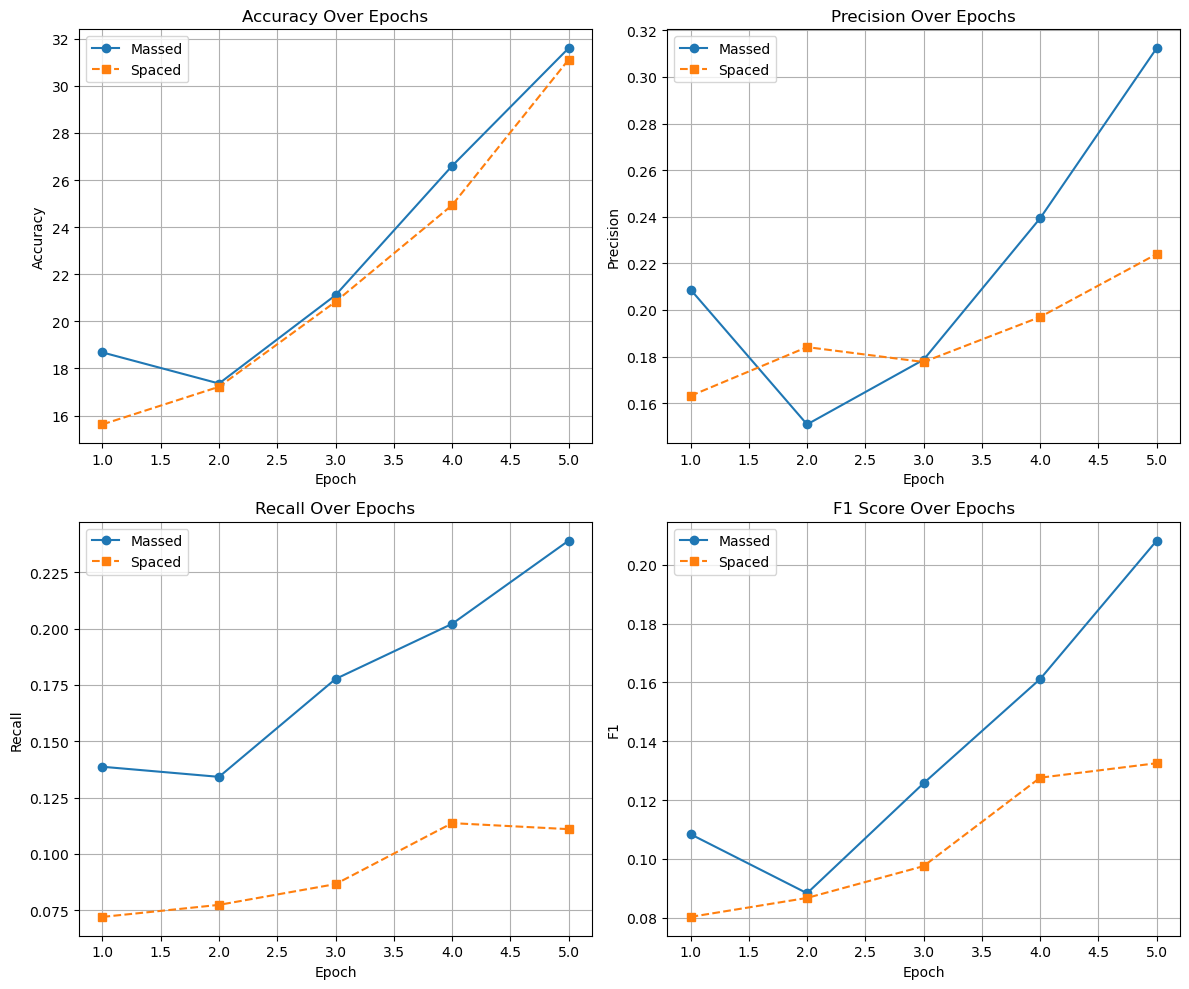

In [36]:
plot_epoch_trends(all_epoch_results_ms)

_______

### **Experiment 2: Noise Levels in Images**

**Objective**: Investigate how introducing noise into images affects retrieval difficulty and model retention over time.

**Training Protocol**
1. Train CNN on clean images
2. Test under different noise conditions:
    a. Low noise (Gaussian noise, σ=0.1)
    b. Medium noise (σ=0.3)
    c. High noise (σ=0.5)

*Note*: To test under different noise conditions, we will modify the image dataset using `torchvision.transforms`. σ parameters are subject to change.

**Benchmark(s)**
1. Compare against standard CNN performance on clean images.
2. Track degradation trends as noise increases.

**Interpretation**
- Retrieval performance drops significantly with noise →  retrieval difficulty negatively affects CNN retention.
- Model adapts well to noise → CNNs may be robust to effortful retrieval.

In [69]:
BATCH_SIZE = 64
NUM_EPOCHS_PHASE1 = 5
NUM_EPOCHS_PHASE2 = 2
RETRIEVAL_NOISE_LEVELS = [0.0, 0.1, 0.3, 0.5]

In [70]:
class AddGaussianNoise(object):
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.sigma
        return torch.clamp(tensor + noise, 0., 1.)

In [108]:
def train_model(model, loader, criterion, optimizer, epochs=1, desc=""):
    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(loader, desc=f"{desc} Epoch {epoch+1}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [109]:
def evaluate_model(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            preds.extend(predictions.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return {
        "accuracy": accuracy_score(labels, preds) * 100,
        "precision": precision_score(labels, preds, average='macro', zero_division=0) * 100,
        "recall": recall_score(labels, preds, average='macro', zero_division=0) * 100,
        "f1": f1_score(labels, preds, average='macro', zero_division=0) * 100
    }

In [79]:
def run_experiment_3_5(subset_fraction=0.2):
    results = {}

    print("Phase 1: Training on a subset of clean CIFAR-10...")

    # Set up clean transform
    transform_clean = transforms.ToTensor()

    # Load the full dataset once
    full_train = CIFAR10(root='./data', train=True, download=True, transform=transform_clean)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_clean)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Create a smaller subset of the training data
    subset_size = int(subset_fraction * len(full_train))
    retrieval_subset, _ = random_split(full_train, [subset_size, len(full_train) - subset_size])

    # Train Phase 1 on clean subset
    model, criterion, optimizer = get_pretrained_cnn()
    train_loader = DataLoader(retrieval_subset, batch_size=BATCH_SIZE, shuffle=True)
    train_model(model, train_loader, criterion, optimizer, epochs=NUM_EPOCHS_PHASE1, desc="Clean Train")

    print("\nPhase 2 & 3: Retrieval-based re-training with noisy subsets and evaluation on clean test set")

    for sigma in RETRIEVAL_NOISE_LEVELS:
        print(f"\n--- Retrieval training with Gaussian noise σ={sigma} ---")

        # Apply noise transform
        transform_noisy = transforms.Compose([
            transforms.ToTensor(),
            AddGaussianNoise(sigma)
        ])
        noisy_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform_noisy)
        noisy_subset = Subset(noisy_dataset, retrieval_subset.indices)
        noisy_loader = DataLoader(noisy_subset, batch_size=BATCH_SIZE, shuffle=True)

        # Copy model to avoid overwriting clean training
        model_retrieval = models.resnet18(weights=None, num_classes=10).to(device)
        model_retrieval.load_state_dict(model.state_dict())
        optimizer_retrieval = torch.optim.Adam(model_retrieval.parameters(), lr=1e-3)

        # Re-train on noisy retrieval subset
        train_model(model_retrieval, noisy_loader, criterion, optimizer_retrieval, epochs=NUM_EPOCHS_PHASE2, desc=f"Retrieval σ={sigma}")

        # Evaluate on clean test set
        metrics = evaluate_model(model_retrieval, test_loader)
        results[sigma] = metrics
        print(f"Evaluation after retrieval (σ={sigma}): {metrics}")

        # Cleanup
        del model_retrieval, optimizer_retrieval
        torch.cuda.empty_cache()

    return results

In [ ]:
results_3_5_cleaned = run_experiment_3_5(subset_fraction=0.1)

In [81]:
display(pd.DataFrame(results_3_5_cleaned))

,0.0,0.1,0.3,0.5
accuracy,58.830000,52.400000,41.770000,16.100000
precision,60.659907,60.223015,60.710652,50.260682
recall,58.830000,52.400000,41.770000,16.100000
f1,58.406551,50.501857,40.435051,12.093604


#### **Visualizations**

In [89]:
def plot_retrieval_metrics(results, title="Gaussian Noise Retrieval Difficulty"):
    sigmas = sorted(results.keys())
    metrics = ["accuracy", "precision", "recall", "f1"]
    colors = ["blue", "green", "orange", "red"]

    plt.figure(figsize=(10, 6))

    for metric, color in zip(metrics, colors):
        values = [results[sigma][metric] for sigma in sigmas]
        plt.plot(sigmas, values, marker='o', label=metric.capitalize(), color=color, alpha=0.5)

    plt.title(title)
    plt.xlabel("Gaussian Noise σ (during retrieval)")
    plt.ylabel("Score (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

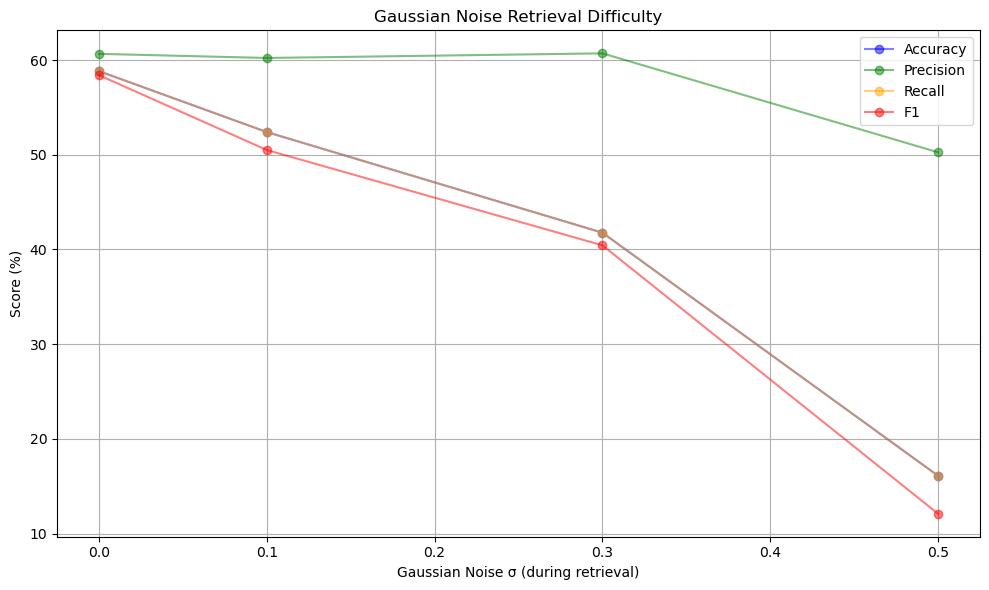

In [90]:
plot_retrieval_metrics(results_3_5_cleaned)

_______

### **Experiment 3: Occluding Parts of Images**

**Objective**: Test whether CNNs can learn to retrieve images even when parts of the input are missing, mimicking retrieval with incomplete cues in human memory.

**Training Protocol**
1. Train on full images
2. Test under occlusion conditions:
    a. 25% occlusion (randomly block part of the image)
    b. 50% occlusion
    c. 75% occlusion

**Benchmark(s)**: Compare against standard CNN performance on full images.

**Interpretation**
- CNNs struggle with occlusion → retrieval difficulty negatively affects performance.
- CNNs maintain accuracy → effortful retrieval mechanisms might apply.

In [101]:
BATCH_SIZE = 64
NUM_EPOCHS_PHASE1 = 5
NUM_EPOCHS_PHASE2 = 2
OCCLUSION_LEVELS = [0.0, 0.25, 0.5, 0.75]
TRAIN_SUBSET_SIZE = 100

In [92]:
class RandomOcclusion(object):
    def __init__(self, occlusion_percent=0.25):
        self.occlusion_percent = occlusion_percent

    def __call__(self, tensor):
        if self.occlusion_percent == 0:
            return tensor

        c, h, w = tensor.shape
        mask_size = int(h * self.occlusion_percent)
        x_start = random.randint(0, w - mask_size)
        y_start = random.randint(0, h - mask_size)
        tensor[:, y_start:y_start + mask_size, x_start:x_start + mask_size] = 0
        return tensor

In [93]:
def train_model(model, loader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [94]:
def evaluate_model(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            preds.extend(predictions.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return {
        "accuracy": accuracy_score(labels, preds) * 100,
        "precision": precision_score(labels, preds, average='macro', zero_division=0) * 100,
        "recall": recall_score(labels, preds, average='macro', zero_division=0) * 100,
        "f1": f1_score(labels, preds, average='macro', zero_division=0) * 100
    }

In [107]:
def run_experiment_4_5(subset_fraction=0.2):
    results = {}

    print("Phase 1: Training on a subset of clean CIFAR-10...")

    # Set up clean transform
    transform_clean = transforms.ToTensor()

    # Load the full dataset once
    full_train = CIFAR10(root='./data', train=True, download=True, transform=transform_clean)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_clean)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Create a smaller subset of the training data
    subset_size = int(subset_fraction * len(full_train))
    retrieval_subset, _ = random_split(full_train, [subset_size, len(full_train) - subset_size])

    # Train Phase 1 on clean subset
    model, criterion, optimizer = get_pretrained_cnn()
    train_loader = DataLoader(retrieval_subset, batch_size=BATCH_SIZE, shuffle=True)
    train_model(model, train_loader, criterion, optimizer, epochs=NUM_EPOCHS_PHASE1, desc="Clean Train")

    print("\nPhase 2 & 3: Retrieval-based re-training with occluded subsets and evaluation on clean test set")

    for perc in OCCLUSION_LEVELS:
        print(f"\n--- Retrieval training with Occlusion %={perc} ---")

        # Apply noise transform
        transform_occluded = transforms.Compose([
            transforms.ToTensor(),
            RandomOcclusion(perc)
        ])
        occluded_dataset = CIFAR10(root='./data', train=True, download=False, transform=transform_occluded)
        occluded_subset = Subset(occluded_dataset, retrieval_subset.indices)
        occluded_loader = DataLoader(occluded_subset, batch_size=BATCH_SIZE, shuffle=True)

        # Copy model to avoid overwriting clean training
        model_retrieval = models.resnet18(weights=None, num_classes=10).to(device)
        model_retrieval.load_state_dict(model.state_dict())
        optimizer_retrieval = torch.optim.Adam(model_retrieval.parameters(), lr=1e-3)

        # Re-train on noisy retrieval subset
        train_model(model_retrieval, occluded_loader, criterion, optimizer_retrieval, epochs=NUM_EPOCHS_PHASE2, desc=f"Retrieval σ={perc}")

        # Evaluate on clean test set
        metrics = evaluate_model(model_retrieval, test_loader)
        results[perc] = metrics
        print(f"Evaluation after retrieval (σ={perc}): {metrics}")

        # Cleanup
        del model_retrieval, optimizer_retrieval
        torch.cuda.empty_cache()

    return results

In [110]:
minimal_results_4_5 = run_experiment_4_5()
display(pd.DataFrame(minimal_results_4_5))

Phase 1: Training on a subset of clean CIFAR-10...


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Phase 2 & 3: Retrieval-based re-training with occluded subsets and evaluation on clean test set

--- Retrieval training with Occlusion %=0.0 ---


Evaluation after retrieval (σ=0.0): {'accuracy': 70.32000000000001, 'precision': 72.75087696287609, 'recall': 70.32000000000001, 'f1': 70.89818870353865}

--- Retrieval training with Occlusion %=0.25 ---


Evaluation after retrieval (σ=0.25): {'accuracy': 71.41, 'precision': 72.71604064351875, 'recall': 71.41, 'f1': 71.36849957399612}

--- Retrieval training with Occlusion %=0.5 ---


Evaluation after retrieval (σ=0.5): {'accuracy': 65.9, 'precision': 69.31130412320357, 'recall': 65.9, 'f1': 65.16028789414375}

--- Retrieval training with Occlusion %=0.75 ---


Evaluation after retrieval (σ=0.75): {'accuracy': 43.82, 'precision': 63.0020526062946, 'recall': 43.82, 'f1': 41.37251964644991}


,0.00,0.25,0.50,0.75
accuracy,70.320000,71.410000,65.900000,43.820000
precision,72.750877,72.716041,69.311304,63.002053
recall,70.320000,71.410000,65.900000,43.820000
f1,70.898189,71.368500,65.160288,41.372520


#### **Visualizations**

In [103]:
def plot_retrieval_metrics(results, title="Occlusion Retrieval Difficulty"):
    sigmas = sorted(results.keys())
    metrics = ["accuracy", "precision", "recall", "f1"]
    colors = ["blue", "green", "orange", "red"]

    plt.figure(figsize=(10, 6))

    for metric, color in zip(metrics, colors):
        values = [results[sigma][metric] for sigma in sigmas]
        plt.plot(sigmas, values, marker='o', label=metric.capitalize(), color=color, alpha=0.5)

    plt.title(title)
    plt.xlabel("Occlusion % (during retrieval)")
    plt.ylabel("Score (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

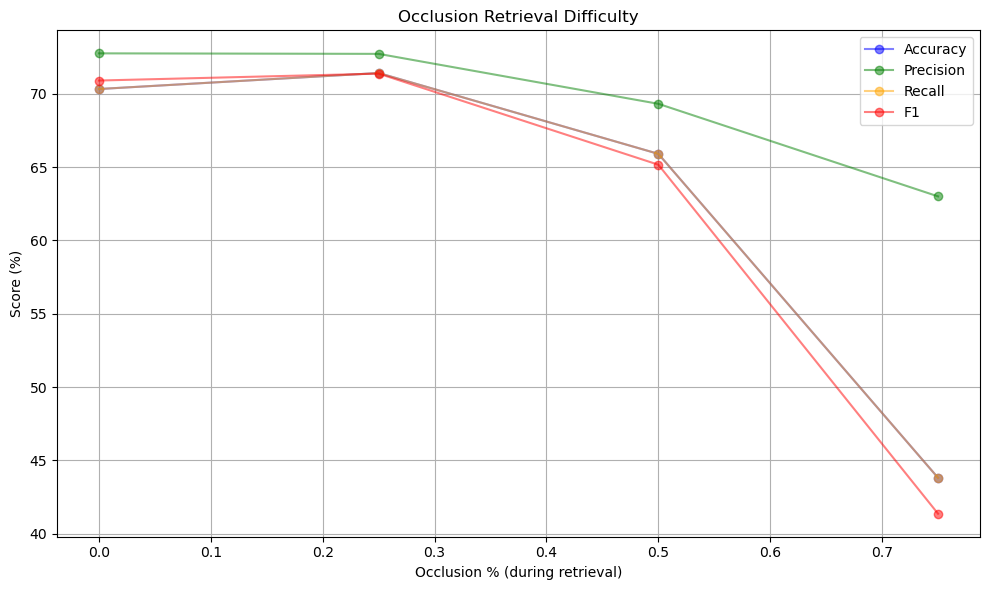

In [112]:
plot_retrieval_metrics(minimal_results_4_5)

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>